# **1 DATA PREPARATION**

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
dataset_path = '../input/weather-dataset/dataset'
class_names = sorted(os.listdir(dataset_path))
class_count = len(class_names)
class_dis = [len(os.listdir(dataset_path + "/" + name)) for name in class_names]
print(class_count)
class_dis

11


[698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]

In [3]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

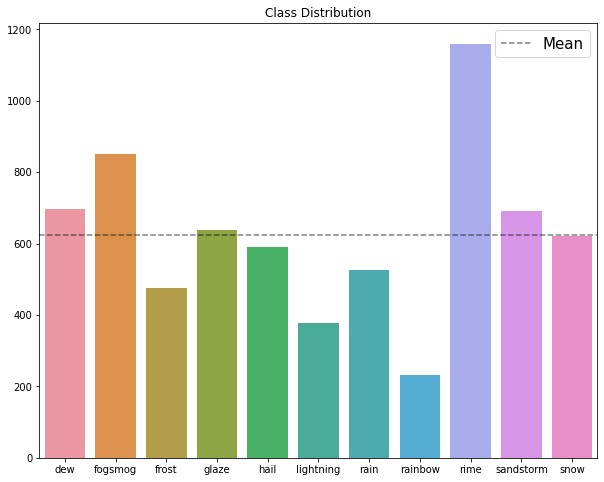

In [4]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

In [5]:
channels=3
batch_size=20
img_size=(256,256)
img_shape=(img_size[0], img_size[1], channels)

# Initialize DataGenerator
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, validation_split=0.2)

# Load Data
train_ds = train_gen.flow_from_directory(dataset_path, target_size=img_size, class_mode="categorical", subset='training', shuffle=True, batch_size=batch_size)
valid_ds = train_gen.flow_from_directory(dataset_path, target_size=img_size, class_mode="categorical", subset='validation', shuffle=True, batch_size=batch_size)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


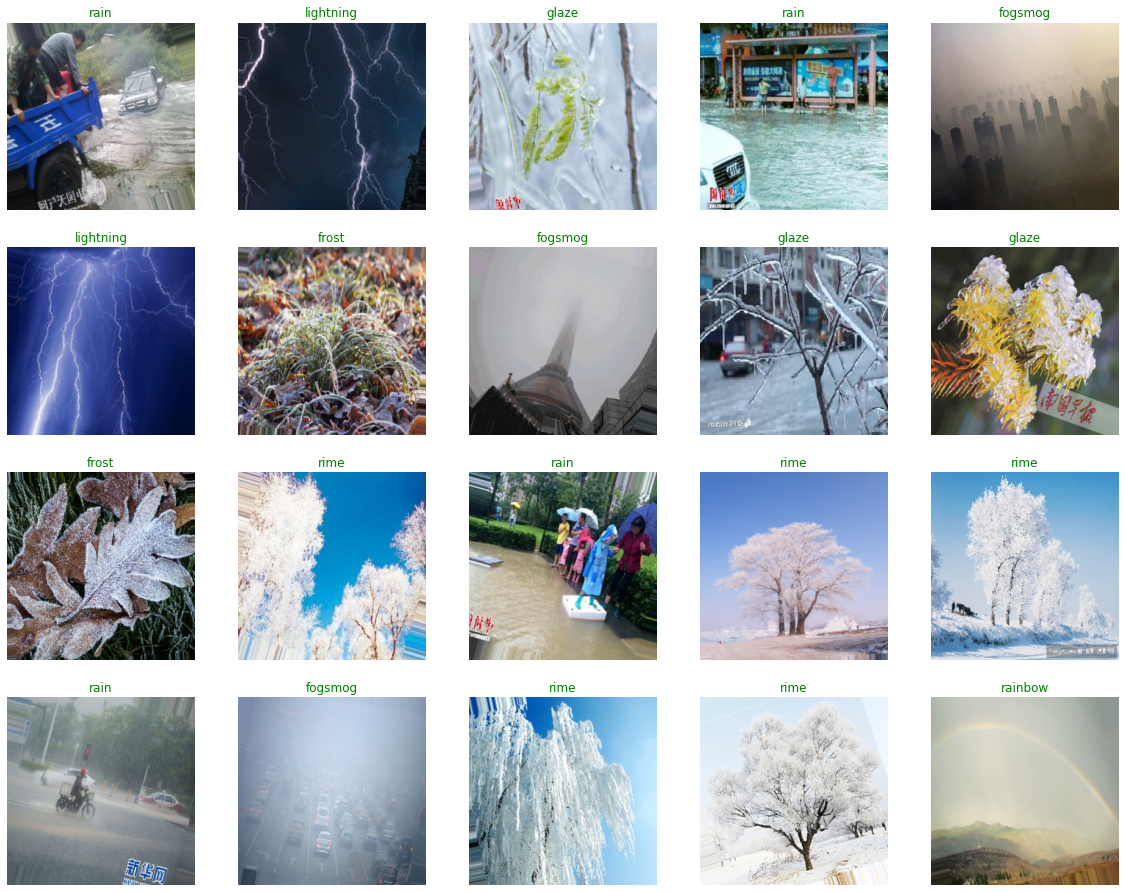

In [6]:
t_dict=train_ds.class_indices
classes=list(t_dict.keys()) 
images,labels=next(train_ds)

plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    image=images[i]
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name=classes[index]
    plt.title(class_name, color='green', fontsize=12)
    plt.axis('off')
plt.show()

In [7]:
model_name='EfficientNetB4'
base_model=tf.keras.applications.EfficientNetB4(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(name='precision')]) 

71696384/71686520 [==============================] - 0s 0us/step


In [8]:
epochs = 10
patience = 1 # number of epochs to wait to adjust lr if monitored value does not improve
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
history = model.fit(x=train_ds,
                    epochs=epochs,
                    validation_data=valid_ds,
                    validation_steps=len(valid_ds),
                    steps_per_epoch=len(train_ds),
                    callbacks=callbacks)

Epoch 1/10
275/275 [==============================] - 232s 761ms/step - loss: 8.4184 - accuracy: 0.6306 - precision: 0.7391 - val_loss: 11.5978 - val_accuracy: 0.0606 - val_precision: 0.0560
Epoch 2/10
275/275 [==============================] - 169s 614ms/step - loss: 6.4613 - accuracy: 0.7968 - precision: 0.8595 - val_loss: 6.8007 - val_accuracy: 0.4887 - val_precision: 0.6954
Epoch 3/10
275/275 [==============================] - 173s 628ms/step - loss: 5.0506 - accuracy: 0.8595 - precision: 0.9133 - val_loss: 5.2871 - val_accuracy: 0.5924 - val_precision: 0.7450
Epoch 4/10
275/275 [==============================] - 171s 620ms/step - loss: 3.9629 - accuracy: 0.8891 - precision: 0.9240 - val_loss: 4.7960 - val_accuracy: 0.4631 - val_precision: 0.6189
Epoch 5/10
275/275 [==============================] - 170s 618ms/step - loss: 3.0869 - accuracy: 0.9070 - precision: 0.9405 - val_loss: 3.3823 - val_accuracy: 0.6713 - val_precision: 0.8078
Epoch 6/10
275/275 [=============================